# Regressione non Lineare

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

## Setup

- Importare i package necessari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- In Jupyter, configurare l'output di matplotlib integrato nel notebook

In [2]:
%matplotlib inline

## Caso di Studio 1: Predizione Consumo Elettricità

- Carichiamo i dati già visti nel laboratorio precedente: per ogni giorno degli anni dal 2015 al 2017 abbiamo la temperatura media in una città e il picco registrato di consumo di corrente elettrica
  - con l'opzione `index_col` specifichiamo che la colonna `date` costituisce l'indice del DataFrame
  - con `parse_dates` indichiamo che i suoi valori vanno interpretati come date

In [ ]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/vpaM1", "power.csv")

In [3]:
data = pd.read_csv("https://git.io/vpaM1", index_col="date", parse_dates=["date"])

In [4]:
data.head(3)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4


## Divisione tra Training e Validation Set

- Abbiamo visto che per verificare se un modello generalizza correttamente i dati su cui è addestrato, è importante **validarlo su dati diversi**
- Il metodo _hold-out_ prevede di dividere i dati a disposizione in un _training set_ su cui addestrare il modello e un _validation set_ su cui verificare l'accuratezza
- A supporto del metodo hold-out, scikit-learn fornisce una funzione `train_test_split` per **suddividere casualmente un set di dati** in due insiemi "train" e "test" disgiunti
  - il set di dati può essere qualsiasi struttura dati sequenziale, di solito array NumPy o serie o DataFrame pandas
  - con l'opzione `test_size=X` si indica la proporzione (se X decimale tra 0 e 1) o il numero di elementi (se X intero) da inserire nel test piuttosto che nel train (default 0.25, ovvero 25\%)
  - con l'opzione `random_state` si indica un seed per la riproducibilità
- Ad esempio, dividiamo il DataFrame `data` in due parti `train_data` e `val_data`, contenenti rispettivamente 2/3 e 1/3 dei dati

In [5]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=1/3, random_state=42)

- I due nuovi DataFrame contengono due sottoinsiemi disgiunti delle righe di `data_summer`, mescolate casualmente

In [6]:
train_data.shape

(730, 2)

In [7]:
train_data.head(3)

,demand,temp
date,,
2017-12-09,1.683743,2.2
2016-09-22,2.320480,30.0
2017-10-12,1.672455,20.0


In [8]:
val_data.shape

(366, 2)

In [9]:
val_data.head(3)

,demand,temp
date,,
2015-02-14,1.981781,-2.2
2016-07-22,2.526696,31.1
2015-02-26,2.086202,-6.1


- A `train_test_split` possiamo passare **due (o più) collezioni** con pari numero di elementi per far sì che siano suddivise insieme, applicando **a tutte lo stesso ordine** casuale dei dati
- Ad esempio separiamo `data` in due strutture dati allineate:
  - un DataFrame X con i valori delle variabili indipendenti (quì una sola, la temperatura)
  - una serie y con i valori della variabile dipendente (il consumo)

In [10]:
X = data[["temp"]]
y = data["demand"]

- Applichiamo quindi `train_test_split` congiuntamente a X e y

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

- Si può verificare che l'ordine delle righe di `X_train` è lo stesso di `y_train` (lo stesso vale per `X_val` e `y_val`)

In [12]:
X_train.head(3)

,temp
date,
2017-12-09,2.2
2016-09-22,30.0
2017-10-12,20.0


In [13]:
y_train.head(3)

date
2017-12-09    1.683743
2016-09-22    2.320480
2017-10-12    1.672455
Name: demand, dtype: float64

In [14]:
np.array_equal(X_train.index, y_train.index)

True

## Ripasso: Modello Lineare

- Abbiamo visto come addestrare con scikit-learn un modello di regressione lineare
  - in tale modello, il valore della variabile dipendente è previsto come somma di quelli delle variabili indipendenti moltiplicati per diversi coefficienti
- Dapprima si crea un modello vuoto

In [15]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()

- Si usa quindi il metodo `fit` per addestrare il modello, passando
  - una matrice con $m\times n$ valori, ovvero $m$ osservazioni di $n$ variabili indipendenti
  - un vettore con i corrispondenti $m$ valori della variabile dipendente
- Addestriamo tale modello sui dati del training set

In [16]:
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Misurare l'Errore del Modello

- Per misurare l'errore che un modello $h(\mathbf{x})$ compie su un set di dati esistono diverse metriche
- L'_errore quadratico medio_ è utilizzato come criterio per individuare il modello migliore
$$ \mathrm{MSE} = \frac{1}{m}\sum_{i=1}^n\left(h(\mathbf{x}_i)-y_i\right)^2 $$
- Per calcolarlo possiamo usare la funzione `mean_squared_error` fornita da scikit-learn nel modulo `metrics`, che definisce diverse misure d'errore dei modelli

In [17]:
from sklearn.metrics import mean_squared_error

- Alla funzione vanno passati il vettore (o serie) dei valori reali della variabile dipendente e il vettore delle corrispondenti predizioni
- Ad esempio, l'errore del modello sopra è:

In [18]:
#                  valori reali   valori predetti
mean_squared_error(y_val,         lrm.predict(X_val))

0.098769168039965632

- Altre misure sono utilizzate per ottenere una stima più facilmente interpretabile dell'errore
- L'_errore relativo_ misura intuitivamente di quanto il modello si sbaglia in percentuale rispetto al valore reale
$$ \mathrm{errore} = \frac{1}{m}\sum_{i=1}^m\left\vert\frac{h(\mathbf{x}_i)-y_i}{y_i}\right\vert $$
- Ad esempio, se il valore reale da predire è 2 GW, ad una stima di 2,2 GW corrisponde un errore relativo del 10\%
- Per questa metrica definiamo una funzione per il calcolo compatibile con quella usata sopra per il MSE

In [19]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

- L'errore relativo del modello sopra è:

In [20]:
relative_error(y_val, lrm.predict(X_val))

0.1394249691231682

- Il _coefficiente di determinazione_ $R^2$ è una misura che esprime intuitivamente quanto il modello catturi la variabilità presente nei dati ($\bar{y}$ = media di $Y$)
$$ R^2 = \frac{\sum_{i=1}^m{\left(y_i-\hat{y}_i\right)^2}}{\sum_{i=1}^m{\left(y_i-\bar{y}\right)^2}} $$
- Questa metrica si può calcolare con la funzione `r2_score` del modulo `metrics` citato sopra

In [21]:
from sklearn.metrics import r2_score
r2_score(y_val, lrm.predict(X_val))

0.16841698449228748

- In alternativa, essendo la metrica di default per i modelli di regressione, si può calcolare col metodo `score` del modello stesso passando le osservazioni delle variabili indipendenti e dipendente

In [22]:
lrm.score(X_val, y_val)

0.16841698449228748

- 0,17 è un valore molto basso, che denota scarsa aderenza del modello ai dati

- Per comodità, creiamo una funzione che calcoli e stampi tutte e tre le metriche su dati e modello forniti
  - `format` introduce valori in una stringa in corrispondenza dei segnaposto `{...}`
  - `{:.5}` indica di stampare un numero con 5 cifre decimali, con `%` lo si stampa in forma percentuale

In [23]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("       Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))

- Testiamola sul modello sopra

In [24]:
print_eval(X_val, y_val, lrm)

   Mean squared error: 0.098769
       Relative error: 14.19269%
R-squared coefficient: 0.16842


## Visualizzazione del Modello

- Definiamo una funzione che, dato un modello basato su una variabile indipendente, mostri la funzione descritta dal modello sovrapposta ai dati
  - la funzione è quella usata nella scorsa esercitazione, adattata per usare modelli di scikit-learn piuttosto che funzioni generiche

In [25]:
def plot_model_on_data(x, y, model=None):
    plt.scatter(x, y)
    if model is not None:
        xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)"); plt.ylabel("Consumi (GW)")

- Usiamo la funzione per visualizzare il modello sovrapposto ai dati su cui è stato addestrato

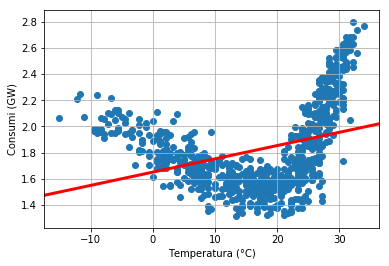

In [26]:
plot_model_on_data(X_train, y_train, lrm)

- Il grafico evidenzia che il consumo non può essere approssimato dalla temperatura in modo soddisfacente con un unico modello lineare (cioè una retta) per tutti i mesi dell'anno

## Regressione Polinomiale

- La regressione _polinomiale_ è una generalizzazione di quella lineare in cui il modello include **termini di grado superiore**
- Ad esempio, mentre un modello di regressione lineare su una singola variabile $x$ (_univariata_) ha forma
$$ \hat{y}=\theta_0+\theta_1\cdot x $$
- in un modello polinomiale di secondo grado viene aggiunto un termine col quadrato della variabile, con un proprio coefficiente:
$$ \hat{y}=\theta_0+\theta_1\cdot x+\theta_2\cdot x^2 $$
- Analogamente, in un modello di terzo grado viene aggiunto un ulteriore termine col cubo della variabile:
$$ \hat{y}=\theta_0+\theta_1\cdot x+\theta_2\cdot x^2+\theta_3\cdot x^3 $$
- La regressione polinomiale corrisponde in pratica a quella lineare con l'aggiunta di variabili derivate da quelle esistenti

## Ottenere Variabili di Grado Superiore

- Per applicare trasformazioni ai dati da fornire ai modelli, scikit-learn fornisce dei _filtri_ con un'interfaccia standard
- Ad esempio, per aggiungere generare le variabili per la regressione polinomiale, usiamo il filtro `PolynomialFeatures`
- In modo simile ai modelli di predizione, un filtro va dapprima creato, impostandone eventuali parametri
- Il parametro più importante di `PolynomialFeatures` è `degree`, che indica il grado massimo delle feature da generare

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

- Alla prima applicazione di un filtro va usato il metodo `fit_transform`, per far sì che il filtro "apprenda" la struttura dei dati
- Ad esempio, creiamo una matrice con due osservazioni (righe) di una generica variabile (colonna) $X$

In [28]:
sample = np.array([ [ 2],
                    [-3] ])

- Usando `fit_transform`, il filtro
  - apprende che qualsiasi input sarà costituito da una sola colonna (`fit`)
  - applica la trasformazione ai dati passati (`transform`)

In [29]:
poly.fit_transform(sample)

array([[  1.,   2.,   4.,   8.],
       [  1.,  -3.,   9., -27.]])

- Dati i valori di $X$, il filtro ha restituito i valori di $X^0, X^1, X^2, X^3$
- Successive trasformazioni su dati con la stessa struttura (cioè una singola colonna) vanno eseguite col metodo `transform`

- La colonna $X^0$ ha sempre valore 1 ed è inutile nell'addestrare il modello (sarebbe ridondante con l'intercetta)
- Possiamo escluderla impostando `include_bias=False` sul filtro

In [30]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(sample)

array([[  2.,   4.,   8.],
       [ -3.,   9., -27.]])

## Addestrare un Modello Polinomiale

- Per addestrare un modello polinomiale possiamo quindi creare il filtro per l'aggiunta delle feature, ad esempio di secondo grado...

In [31]:
poly = PolynomialFeatures(degree=2, include_bias=False)

- ...e addestrare un modello lineare con i dati trasformati

In [32]:
prm = LinearRegression()
prm.fit(poly.fit_transform(X_train), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- In seguito, i valori della _x_ dovranno sempre essere trasformati con lo stesso filtro, utilizzando il metodo `transform`
- Ad esempio, per ottenere i consumi predetti a fronte di temperature di -5 °C, 5 °C e 25 °C...

In [33]:
prm.predict(poly.transform([ [-5], [5], [25] ]))

array([ 2.04296683,  1.59799297,  1.91411279])

## Accuratezza del Modello Polinomiale

- Calcolando le solite misure d'errore su questo nuovo modello...

In [34]:
print_eval(poly.transform(X_val), y_val, prm)

   Mean squared error: 0.031921
       Relative error: 7.60952%
R-squared coefficient: 0.73124


- ...otteniamo risultati molto migliori di quelli che avevamo ottenuto col modello lineare

In [35]:
print_eval(X_val, y_val, lrm)

   Mean squared error: 0.098769
       Relative error: 14.19269%
R-squared coefficient: 0.16842


## Pipeline

- Nelle istruzioni sopra, ad ogni interazione col modello `prm`, abbiamo dovuto esplicitamente trasformare i dati col filtro `poly`
- scikit-learn permette di comporre uno o più filtri con un modello creando una **_pipeline_**
- Una volta costruita, la pipeline offre la **stessa API del modello** di predizione incapsulato, ma **applica automaticamente i filtri** ai dati prima di passarli al modello
  - chiamando `fit`, i filtri sono "tarati" e applicati (`fit_transform`) sui dati di addestramento
  - chiamando `predict` (o `score`), i filtri (già tarati) sono nuovamente applicati ai nuovi dati (`transform`)
- Ad esempio, per incapsulare il modello polinomiale visto sopra in un oggetto unico, usiamo una pipeline con il filtro `PolynomialFeatures` e il modello lineare
  - al costruttore va passata la lista ordinata dei componenti, ciascuno rappresentato da una tupla con nome e componente

In [36]:
from sklearn.pipeline import Pipeline
prm = Pipeline([
    # nome     elemento
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])

- Possiamo ora eseguire le stesse operazioni vista sopra sul modello, ma con la trasformazione dei dati applicata in automatico

In [37]:
prm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [38]:
prm.predict([ [-5], [5], [25] ])

array([ 2.04296683,  1.59799297,  1.91411279])

In [39]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.031921
       Relative error: 7.60952%
R-squared coefficient: 0.73124


## Curva del Modello Polinomiale

- Visualizzando il modello polinomiale di secondo grado in un grafico, vediamo che ha la forma di una funzione $a\cdot x^2+b\cdot x+c$, ovvero una parabola

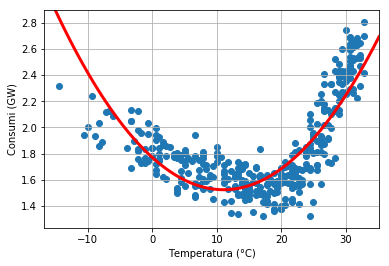

In [40]:
plot_model_on_data(X_val, y_val, prm)

- Come anche confermato dalle misure di errore, questo modello approssima molto meglio il consumo in base alla temperatura rispetto a quello lineare

## Standardizzazione dei Dati

- Data una variabile $X$ con media $\mu$ e deviazione standard $\sigma$, la sua versione "standard" è calcolata come
$$ Z = \frac{X-\mu}{\sigma} $$
- $Z$ mantiene la distribuzione dei dati di $X$, ma con media 0 e deviazione standard 1
- In presenza di più variabili con scale diverse, applicare la standardizzazione a ciascuna di esse è utile per uniformarne i valori
- Questo può migliorare l'accuratezza dei modelli di regressione

- La standardizzazione si esegue col filtro `StandardScaler`
- Eseguendo `fit_transform` (o `fit`) il filtro memorizza medie e deviazioni standard dei dati passati

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform([[0.001, 4000],
                      [0.002, 2500],
                      [0.004, 1000]])

array([[-1.06904497,  1.22474487],
       [-0.26726124,  0.        ],
       [ 1.33630621, -1.22474487]])

- Successivamente `transform` trasformerà ulteriori dati secondo medie e deviazioni memorizzate

In [42]:
scaler.transform([ [0.01, 100] ])

array([[ 6.14700856, -1.95959179]])

- Addestriamo un modello polinomiale di secondo grado come quello sopra, ma applicando la standardizzazione alle variabili $X$ e $X^2$
- Per far ciò, basta aggiungere il filtro alla pipeline

In [43]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),   # <- aggiunto
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

- Valutiamo l'accuratezza del modello

In [44]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.031921
       Relative error: 7.60952%
R-squared coefficient: 0.73124


- In questo caso le metriche di accuratezza non sono cambiate standardizzando i dati
- Ma cosa succede con più variabili con ordini di grandezza molto diversi?

- Addestriamo e valutiamo un nuovo modello polinomiale, questa volta di grado 15, quindi con variabili $X,X^2,\ldots,X^{15}$

In [45]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=15, include_bias=False)),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 0.023056
       Relative error: 6.52101%
R-squared coefficient: 0.80588


- Addestriamo e valutiamo lo stesso modello applicando la standardizzazione

In [46]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=15, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 0.018719
       Relative error: 5.84395%
R-squared coefficient: 0.84239


- Avendo a che fare con molte variabili di ordini di grandezza diversi, la standardizzazione ha migliorato l'accuratezza del modello

## Regolarizzazione e Regressione Ridge

- Abbiamo visto come l'addestramento di un modello si compia minimizzando l'errore sui dati di addestramento, dato da
$$ E = \mathrm{media}\left(\left(\mathbf{X}\mathbf{\theta}-\mathbf{y}\right)^2\right) $$
- Per l'esattezza, la formula su cui si basa `LinearRegression` è
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 $$
- Dove la _norma euclidea_ (o _norma 2_) $\left\Vert\mathbf{x}\right\Vert_2$ di un vettore $\mathbf{x}$ di $n$ elementi è
$$ \left\Vert\mathbf{x}\right\Vert_2 = \sqrt{\sum_{i=1}^n x_i^2} = \sqrt{x_1^2+\ldots+x_n^2} $$
- Tuttavia, questo non garantisce l'accuratezza del modello in generale
- Soprattutto se il modello ha molti parametri, è possibile che questi vengano "forzati" a funzionare bene sui dati d'addestramento, rendendo però il modello poco accurato in generale

- Addestriamo ad esempio un modello polinomiale di grado 20

In [47]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=20, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=20, include_bias=False, interaction_only=False)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

- Valutiamone le misure di accuratezza sia sul training set che sul validation set

In [48]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.021281
       Relative error: 6.04719%
R-squared coefficient: 0.79352


In [49]:
print_eval(X_val, y_val, prm)

   Mean squared error: 0.045654
       Relative error: 6.90762%
R-squared coefficient: 0.61562


- La differenza tra le misure suggerisce che il modello sia stato addestrato "troppo bene" sul training set ma non sia abbastanza generale (_overfitting_)

- A dimostrazione, si veda il grafico del modello sovrapposto ai dati del training set

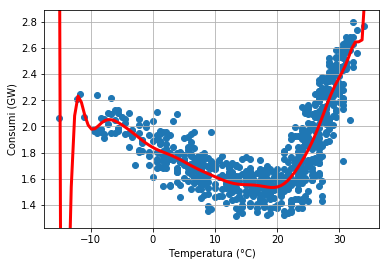

In [50]:
plot_model_on_data(X_train, y_train, prm)

- Soprattutto nella parte a sinistra, si nota che il modello è stato ottimizzato per minimizzare l'errore anche in casi limite del training set

- Vediamo ora il modello sovrapposto al validation set

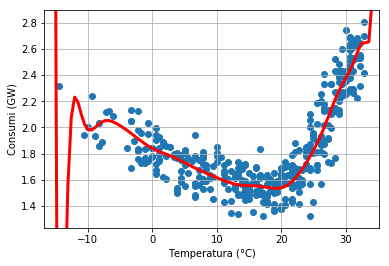

In [51]:
plot_model_on_data(X_val, y_val, prm)

- Si nota che nei casi estremi del validation set, diversi da quelli del training set, l'errore del modello è molto alto

- Vediamo quali sono i coefficienti del modello addestrato
  - `named_steps[X]` permette di accedere al componente col nome `X` della pipeline: lo usiamo per accedere al modello

In [52]:
prm.named_steps["linreg"].coef_

array([ -2.78425409e-01,   1.09957001e+00,  -2.24250753e+00,
        -4.79597331e+01,   1.00699408e+02,   1.17577395e+03,
        -2.98858428e+03,  -1.54753966e+04,   5.73472353e+04,
         6.41449487e+04,  -5.13525757e+05,   4.02789811e+05,
         1.66508061e+06,  -3.83967106e+06,   1.18036583e+06,
         6.10991066e+06,  -1.04950118e+07,   7.96138979e+06,
        -3.06223172e+06,   4.86648551e+05])

- I coefficienti per i termini di grado più alto sono molto alti in valore assoluto (${10}^6$)
- Questo causa l'andamento irregolare del modello nei casi estremi e i conseguenti errori
- Come evitare che i coefficienti assumano tali valori?

- La **_regolarizzazione_** modifica la funzione d'errore su cui si basa l'addestramento, aggiungendo una penalità per valori estremi dei parametri del modello
- Nella regolarizzazione _L2_, la più comune, la penalità è proporzionale al quadrato della norma euclidea del vettore $\mathbf{\theta}$ dei parametri
  - in questo modo parametri molto alti in valore assoluto sono molto penalizzati
- La regressione _ridge_ consiste nella regressione lineare con applicata la regolarizzazione L2, utilizzando quindi la seguente funzione d'errore:
$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_2^2 $$
- $\alpha$ è un parametro impostabile dall'utente che controlla il "peso" della regolarizzazione
  - tali parametri impostabili sono a volte detti _iperparametri_ per distinguerli dai parametri addestrabili del modello

- Per eseguire la regressione ridge usiamo un modello `Ridge`
- Alla creazione del modello è possibile specificare il peso della regolarizzazione con l'opzione `alpha`
- Per il resto l'API della classe `Ridge` è identica a quella di `LinearRegression`, possiamo quindi sostituirla nella pipeline

In [53]:
from sklearn.linear_model import Ridge
rrm = Pipeline([
    ("poly",   PolynomialFeatures(degree=20, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge(alpha=1))
])
rrm.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=20, include_bias=False, interaction_only=False)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

- Verifichiamo i coefficienti del modello addestrato

In [54]:
rrm.named_steps["linreg"].coef_

array([ -2.55052849e-01,  -2.05065281e-02,   6.41146671e-02,
         7.90674102e-02,   1.34673035e-01,   1.34780143e-01,
         1.27965196e-01,   9.56779884e-02,   5.83152213e-02,
         1.64816267e-02,  -2.08792706e-02,  -5.13070390e-02,
        -7.13742015e-02,  -8.00724263e-02,  -7.67644651e-02,
        -6.18051460e-02,  -3.59146609e-02,  -2.09656636e-04,
         4.40252048e-02,   9.53946432e-02])

- Vediamo che questa volta sono tutti inferiori a 1 in valore assoluto, per effetto della regolarizzazione

- Con tali, coefficienti, il modello ha un comportamento regolare anche per casi estremi, come si può vedere dal grafico

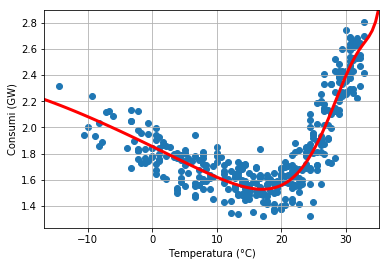

In [55]:
plot_model_on_data(X_val, y_val, rrm)

- Verifichiamo l'accuratezza su training e validation set

In [56]:
print_eval(X_train, y_train, rrm)

   Mean squared error: 0.021587
       Relative error: 6.14427%
R-squared coefficient: 0.79055


In [57]:
print_eval(X_val, y_val, rrm)

   Mean squared error: 0.018798
       Relative error: 5.85777%
R-squared coefficient: 0.84173


- Vediamo che le misure sul training set sono leggermente peggiori di quelle senza regolarizzazione, ma quelle sul validation set sono nettamente migliori

## Esercizi A: Regressione polinomiale al variare del grado

- **1)** Definire una funzione `test_regression` con parametri `degree` e `alpha` che
  - definisca un modello di regressione polinomiale di grado `degree` con standardizzazione dei dati e regolarizzazione L2 con peso `alpha`
  - addestri tale modello sui dati `X_train`, `y_train`
  - restituisca il coefficiente R² del modello calcolato sui dati `X_val`, `y_val`
- **2)** Generare una lista, array o serie di valori restituiti dalla funzione con `alpha=1` e `degree` variabile con valori 5, 10, 15, ..., 50
- **3)** Visualizzare tali risultati in un grafico a linea

## Caso di Studio 2: Predizione dei Prezzi delle Case

- Riprendiamo dalla scorsa esercitazione il dataset relativo ai prezzi delle case
- Forniamo tale dataset all'URL _(da caricare)_ già adattato per essere caricato con `read_csv` con le opzioni di default

In [ ]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/fjGjx", "housing.csv")

In [58]:
housing = pd.read_csv("housing.csv")

In [59]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- Eseguiamo la divisione casuale tra training e validation set come sopra
  - la variabile dipendente y è MEDV, il prezzo delle case
  - le variabili indipendenti X sono tutte le altre

In [60]:
X_train, X_val, y_train, y_val = train_test_split(
    housing.drop("MEDV", axis=1),    # X = tutto tranne MEDV
    housing["MEDV"],                 # y = MEDV
    test_size=1/3, random_state=42   # parametri divisione
)

- Addestriamo e valutiamo dapprima un modello lineare semplice

In [61]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
print_eval(X_val, y_val, model)

   Mean squared error: 20.595
       Relative error: 81.54604%
R-squared coefficient: 0.72621


- Osservando i coefficienti del modello etichettati con i nomi delle colonne, possiamo dedurre il peso che ciascuna variabile ha nella predizione
- Tuttavia, tali pesi dipendono molto dalla scala delle variabili

In [63]:
pd.Series(model.coef_, index=X_train.columns)

CRIM       -0.129470
ZN          0.037960
INDUS       0.060978
CHAS        3.213498
NOX       -16.499614
RM          3.911519
AGE        -0.012602
DIS        -1.427742
RAD         0.239546
TAX        -0.008180
PTRATIO    -0.935991
B           0.011948
LSTAT      -0.546562
dtype: float64

- Applichiamo la standardizzazione ai dati del modello

In [64]:
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [65]:
print_eval(X_val, y_val, model)

   Mean squared error: 20.595
       Relative error: 81.54604%
R-squared coefficient: 0.72621


- In questo modo anche i coefficienti sono normalizzati, permettendone un confronto alla pari

In [66]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

CRIM      -0.995690
ZN         0.872971
INDUS      0.424808
CHAS       0.857462
NOX       -1.943856
RM         2.820988
AGE       -0.351939
DIS       -3.063072
RAD        2.069621
TAX       -1.356887
PTRATIO   -2.098051
B          1.060004
LSTAT     -3.926623
dtype: float64

## Regressione Lasso

- La regolarizzazione L2 impedisce che i parametri del modello assumano valori troppo alti
- I valori dei parametri sono comunque tutti non nulli, tutte le variabili vengono coinvolte nella predizione
- Vorremmo addestrare un modello meno complesso, dove alcuni parametri hanno valori nulli, **ignorando completamente le variabili meno rilevanti**
  - ad es. variabili con valori dipendenti da altre (_multicollinearità_)
- Questo si può ottenere tramite la regolarizzazione L1, basata sulla norma 1, definita su un vettore $\mathbf{x}$ di $n$ elementi come
$$ \left\Vert\mathbf{x}\right\Vert_1 = \sum_{i=1}^n{\left\vert x_i\right\vert} = \left\vert x_1\right\vert+\ldots+\left\vert x_n\right\vert $$

- La regressione _lasso_ consiste nella regressione lineare con regolarizzazione L1, basata quindi sul minimizzare la funzione d'errore
$$ E = \frac{1}{2m}\left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 + \alpha\left\Vert\mathbf{\theta}\right\Vert_1 $$
- Come per la regressione ridge, il parametro $\alpha$ controlla il peso della regolarizzazione
- La regressione lasso si esegue usando un modello `Lasso`, su cui possiamo impostare come in `Ridge` il parametro `alpha`

In [67]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Lasso(alpha=2))
])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', Lasso(alpha=2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

- Vediamo i coefficienti del modello risultante

In [68]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

CRIM      -0.000000
ZN         0.000000
INDUS     -0.000000
CHAS       0.000000
NOX       -0.000000
RM         2.137434
AGE       -0.000000
DIS        0.000000
RAD       -0.000000
TAX       -0.000000
PTRATIO   -0.571281
B          0.000000
LSTAT     -3.490547
dtype: float64

- La regolarizzazione L1 ha contribuito ad annullare quanti più coefficienti possibile, creando un modello che considera solo 3 variabili
- Ma qual'è l'accuratezza di tale modello?

In [69]:
print_eval(X_val, y_val, model)

   Mean squared error: 30.795
       Relative error: 19.28526%
R-squared coefficient: 0.59062


- L'accuratezza è nettamente peggiore rispetto ai casi precedenti
- In questo caso la regolarizzazione è stata quindi eccessiva

- Cosa succede diminuendo il parametro `alpha`, ovvero il peso della regolarizzazione?

In [70]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Lasso(alpha=0.1)) # <-- cambiato da 2
])
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linreg', Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [71]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

CRIM      -0.677400
ZN         0.434023
INDUS     -0.000000
CHAS       0.873061
NOX       -1.392679
RM         2.903934
AGE       -0.173488
DIS       -2.273983
RAD        0.501967
TAX       -0.000000
PTRATIO   -1.909058
B          0.953566
LSTAT     -3.961146
dtype: float64

- I coefficienti non nulli sono aumentati da 5 a 11

In [72]:
print_eval(X_val, y_val, model)

   Mean squared error: 21.636
       Relative error: 41.77503%
R-squared coefficient: 0.71237


- L'accuratezza è simile a quella ottenuta col modello di regressione ridge
- Questo modello è però molto più semplice, in quanto si basa su 7 variabili invece di 20

## Elastic Net

- La regressione _elastic net_ combina insieme le regolarizzazioni L2 e L1 usate in ridge e lasso
- Si applica in scikit-learn tramite la classe `ElasticNet`, per cui l'errore è calcolato come:
$$ E = \underbrace{\frac{1}{2m} ||X\theta - y||_2 ^ 2}_{\text{errore sui dati}} + \underbrace{\alpha \rho ||\theta||_1}_{\text{L1}} + \underbrace{\frac{\alpha(1-\rho)}{2} ||\theta||_2 ^ 2}_{\text{L2}} $$
- I parametri impostabili sono
  - `alpha` ($\alpha$) che determina il peso generale della regolarizzazione
  - `l1_ratio` ($\rho$, compreso tra 0 e 1) che determina il peso di L1 relativo al totale (con $\rho=1$ si ha la regressione lasso, con $\rho=0$ la ridge)

In [73]:
from sklearn.linear_model import ElasticNet
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error: 22.092
       Relative error: 27.75110%
R-squared coefficient: 0.70631


## Regressione Polinomiale Multivariata

- Abbiamo visto sopra che la regressione polinomiale su una sola variabile $X$ (univariata) usa le variabili $X,X^2,X^3,\ldots$
- In presenza di più di una variabile, la regressione polinomiale genera tutti i possibili termini fino al grado impostato, includendo anche **termini basati su più variabili**
- Vediamo un esempio con 2 generiche variabili $A$ e $B$

In [74]:
#                     A   B
sample = np.array([ [ 2, -3],
                    [ 4, -5] ])

- Applicando il filtro `PolynomialFeatures` con grado 2...

In [75]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(sample)

array([[  2.,  -3.,   4.,  -6.,   9.],
       [  4.,  -5.,  16., -20.,  25.]])

- Le variabili generate (escludendo il grado nullo) sono 5: $A,B,A^2,AB,B^2$
- Oltre ai quadrati delle singole variabili abbiamo quindi anche i prodotti tra di esse

- Aumentando il grado massimo, le variabili generate **aumentano rapidamente**
- Ad esempio, aumentando il grado da 2 a 3...

In [76]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(sample)

array([[   2.,   -3.,    4.,   -6.,    9.,    8.,  -12.,   18.,  -27.],
       [   4.,   -5.,   16.,  -20.,   25.,   64.,  -80.,  100., -125.]])

- ...generiamo 9 variabili: $A,B,A^2,AB,B^2,A^3,A^2B,AB^2,B^3$

- Cosa succede con un numero iniziale di variabili più alto?
- Prendiamo ad esempio la matrice `X_train`, con 13 variabili

In [77]:
X_train.shape

(337, 13)

- Generando le feature polinomiali con grado massimo 2...

In [78]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(X_train).shape

(337, 104)

- ...otteniamo 104 feature distinte!

- Aumentando ulteriormente il grado, il numero di variabili cresce enormemente
  - con grado 10 si supera il milione di variabili

In [79]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(X_train).shape

(337, 559)

In [80]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit_transform(X_train).shape

(337, 2379)

In [81]:
poly = PolynomialFeatures(degree=8, include_bias=False)
poly.fit_transform(X_train).shape

(337, 203489)

- All'aumentare delle variabili, aumenta il tempo necessario per l'addestramento del modello
- Proviamo ad esempio ad addestrare un modello polinomiale di grado 2
- Usiamo il comando "magico" `%time` per riportare in output il tempo di esecuzione

In [82]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.5, l1_ratio=0.2))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: user 8.26 ms, sys: 0 ns, total: 8.26 ms
Wall time: 9.74 ms
   Mean squared error: 19.854
       Relative error: 19.59672%
R-squared coefficient: 0.73606


- L'addestramento richiede pochi centesimi di secondo

- Verifichiamo ora cosa accade con grado 5

In [83]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=5, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=0.5, l1_ratio=0.2))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

/home/pasolini/software/miniconda3/envs/dialab/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


CPU times: user 2.98 s, sys: 107 ms, total: 3.09 s
Wall time: 2.52 s
   Mean squared error: 11.969
       Relative error: 13.09187%
R-squared coefficient: 0.84089


- L'accuratezza del modello è migliorata sensibilmente, ma **il tempo per addestrarlo è aumentato di oltre 100 volte**
  - con dataset più grandi, avremmo tempi di addestramento insostenibili

## Regressione con Funzioni Kernel

- Nella regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente
- Le _funzioni kernel_ permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte
- Questo permette di ottenere modelli non lineari senza l'aggiunta di variabili
- Esistono diverse funzioni kernel utilizzabili con diversi parametri impostabili
- Ad esempio, il kernel polinomiale è definito dalla formula
$$ K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $$
  - $d$ e $c$ sono parametri del kernel, in particolare $d$ è il grado del polinomio

- La classe `KernelRidge` implementa la regressione ridge con l'applicazione di una funzione kernel
- Col parametro `kernel` si indica il tipo di kernel con una stringa, ad es. `"poly"` per un kernel polinomiale
- Ulteriori parametri riguardano il kernel, per quello polinomiale sono `degree` ($d$) e `coef0` ($c$)

In [84]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 25.5 ms
   Mean squared error: 14.765
       Relative error: 13.59065%
R-squared coefficient: 0.80371


- Abbiamo ottenuto un'accuratezza più elevata rispetto ai modelli lineari, ma in tempi molto più brevi rispetto alla regressione polinomiale

- Possiamo testare anche funzioni kernel diverse, ad esempio RBF (_radial basis function_)
  - RBF ha valori tanto più elevati quanto più i valori X sono vicini a 0 (ovvero la media, usando dati standardizzati)
- La funzione RBF ha la forma di una gaussiana, di cui si può impostare l'ampiezza col parametro `gamma`

In [85]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="rbf", gamma=0.001))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: user 48.4 ms, sys: 7.29 ms, total: 55.7 ms
Wall time: 22.5 ms
   Mean squared error: 63.544
       Relative error: 25.64160%
R-squared coefficient: 0.15525


- In questo caso specifico il kernel RBF non funziona bene tanto quanto il polinomiale

## k-Fold Cross Validation

- Il metodo _k-fold_ è un'alternativa al metodo hold-out per valutare l'accuratezza di un modello
  - i dati sono divisi causalmente in k gruppi (_fold_)
  - ciascun gruppo è validato su un modello addestrato su tutti gli altri gruppi
  - i risultati dei singoli test sono aggregati
- Per iniziare, definiamo gli oggetti `X` e `y` con i valori di variabili indipendenti e dipendente dell'intero dataset, invece di usare le partizioni create con `train_test_split`

In [86]:
X = housing.drop(["MEDV"], axis=1)
y = housing["MEDV"]

- La classe `KFold` definisce oggetti che generano un dato numero di fold su un insieme di dati
- Creiamo ad esempio un oggetto che genera 5 fold con dati mescolati casualmente

In [87]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

- La funzione `cross_val_score` esegue una validazione di un modello sui diversi fold generati da un set di dati
- Alla funzione vanno passati
  - la definizione di un modello, che viene addestrato una volta per ciascun fold
  - i dati, divisi come per `fit` in valori delle variabili indipendenti (X) e di quella dipendente (y)
  - l'oggetto che genera i fold dai dati
- Utilizziamo ad esempio un modello polinomiale di grado 2 senza regolarizzazione

In [88]:
from sklearn.model_selection import cross_val_score
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
scores = cross_val_score(model, X, y, cv=kf)

- La funzione restituisce il risultato di `score`, ovvero il coefficiente R², calcolato su ciascun fold

In [89]:
scores

array([ 0.80558294,  0.78699438,  0.76305893,  0.91222428,  0.83023822])

- Calcoliamo media e deviazione standard di tali punteggi

In [90]:
scores.mean(), scores.std()

(0.81961974956474282, 0.051281426990241886)

- Il punteggio medio dei modelli è 0,82 con una deviazione standard di 0,05
- Tale valutazione è più affidabile di quella col metodo hold-out, ottenuta da un singolo modello
- Ci permette inoltre di valutare la "robustezza" del modello, ovvero quanto l'accuratezza sia stabile addestrandosi su set di dati diversi

- Riproviamo ad esempio la cross-validation con modello polinomiale come sopra, ma con regolarizzazione L2

In [91]:
model = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
scores = cross_val_score(model, X, y, cv=kf)
scores

array([ 0.84717914,  0.83199436,  0.83630888,  0.91408914,  0.8335903 ])

In [92]:
scores.mean(), scores.std()

(0.85263236377614127, 0.031182228189275522)

- I valori di R² individuati, oltre ad essere più alti in media, hanno una variabilità più bassa rispetto a quelli sopra

## Grid Search

- Sui modelli utilizzati finora abbiamo impostato manualmente i valori di diversi iperparametri
  - grado della regressione polinomiale, peso della regolarizzazione, ...
- L'accuratezza del modello può dipendere fortemente da questi valori
- Scelto un generico modello da utilizzare (es. regressione polinomiale o kernel ridge), vorremmo **individuare i valori degli iperparametri che ne massimizzino l'accuratezza**
- scikit-learn fornisce un supporto per eseguire automaticamente la cross validation un modello con diversi valori degli iperparametri tramite la _grid search_

- Consideriamo ad esempio un modello _elastic net_ di cui fissiamo arbitrariamente il parametro `l1_ratio`

In [93]:
model = ElasticNet(l1_ratio=0.2)

- Vorremmo trovare il migliore valore possibile del parametro `alpha` tra un insieme di valori possibili, ovvero:

In [94]:
candidate_alphas = [0.1, 1, 10]

- Creiamo ora la _griglia_ dei parametri, ovvero un dizionario in cui associamo ai nomi dei parametri variabili i valori che possono assumere
- In questo caso abbiamo un unico parametro variabile, `alpha`

In [95]:
grid = {"alpha": candidate_alphas}

- Definiamo ora un modello `GridSearchCV` indicando
  - il modello "base" con i parametri fissati a priori
  - la griglia dei parametri variabili

In [96]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, param_grid=grid)

- Come per i modelli base, usiamo il metodo `fit` per eseguire l'addestramento, passando la matrice X e il vettore y
- Per ogni valore possibile di `alpha`, scikit-learn esegue la cross-validation per calcolare il punteggio R² medio del modello con quel valore di `alpha`
  - di default si esegue cross-validation con 3 fold

In [97]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 1, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

- In seguito ai test, il modello viene (di default) riaddestrato su tutti i dati, usando gli iperparametri che han dato il miglior punteggio medio
- Possiamo quindi utilizzarlo come un modello ordinario

In [98]:
# prezzo predetto per la prima riga del validation set
gs.predict(X_val.iloc[[0]])

array([ 28.35759953])

In [99]:
print_eval(X_val, y_val, gs)

   Mean squared error: 21.905
       Relative error: 22.68926%
R-squared coefficient: 0.7088


- Dall'attributo `best_params_` possiamo vedere quali sono i valori selezionati degli iperparametri per tale modello

In [100]:
gs.best_params_

{'alpha': 0.1}

- L'attributo `cv_results_` fornisce risultati dettagliati su tutti gli iperparametri testati

In [101]:
gs.cv_results_

{'mean_fit_time': array([ 0.00187612,  0.00180602,  0.00200399]),
 'mean_score_time': array([ 0.00036963,  0.00037026,  0.00038815]),
 'mean_test_score': array([ 0.69311139,  0.65786569,  0.56179024]),
 'mean_train_score': array([ 0.72838963,  0.68982278,  0.58456329]),
 'param_alpha': masked_array(data = [0.1 1 10],
              mask = [False False False],
        fill_value = ?),
 'params': ({'alpha': 0.1}, {'alpha': 1}, {'alpha': 10}),
 'rank_test_score': array([1, 2, 3], dtype=int32),
 'split0_test_score': array([ 0.68144422,  0.68502031,  0.61945439]),
 'split0_train_score': array([ 0.74951813,  0.69517926,  0.56987566]),
 'split1_test_score': array([ 0.73833888,  0.67469173,  0.57072577]),
 'split1_train_score': array([ 0.69238995,  0.66489684,  0.57200556]),
 'split2_test_score': array([ 0.65965525,  0.61364258,  0.49467571]),
 'split2_train_score': array([ 0.74326081,  0.70939224,  0.61180866]),
 'std_fit_time': array([  1.25567772e-04,   2.39900118e-05,   3.58121602e-04]),
 '

- Incapsuliamo tali risultati in un DataFrame per visualizzarli meglio ed ordinarli per punteggio decrescente

In [102]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001876,0.000370,0.693111,0.728390,0.1,{'alpha': 0.1},1,0.681444,0.749518,0.738339,0.692390,0.659655,0.743261,0.000126,1.227541e-05,0.033128,0.025583
1,0.001806,0.000370,0.657866,0.689823,1,{'alpha': 1},2,0.685020,0.695179,0.674692,0.664897,0.613643,0.709392,0.000024,3.371748e-07,0.031485,0.018556
2,0.002004,0.000388,0.561790,0.584563,10,{'alpha': 10},3,0.619454,0.569876,0.570726,0.572006,0.494676,0.611809,0.000358,3.911664e-05,0.051366,0.019285


- Cosa succede con due iperparametri variabili?
- Oltre a 3 valori possibili per `alpha`, impostiamo 3 valori possibili anche per `l1_ratio`

In [103]:
model = ElasticNet()
grid = {
    "alpha":    [0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, param_grid=grid)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 1, 10], 'l1_ratio': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [104]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_l1_ratio,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.001633,0.000348,0.693266,0.728718,0.1,0.3,"{'alpha': 0.1, 'l1_ratio': 0.3}",1,0.680593,0.750202,0.739205,0.692489,0.660113,0.743462,0.000050,2.247832e-07,0.033474,0.025765
1,0.001850,0.000379,0.693111,0.728390,0.1,0.2,"{'alpha': 0.1, 'l1_ratio': 0.2}",2,0.681444,0.749518,0.738339,0.692390,0.659655,0.743261,0.000353,3.282393e-05,0.033128,0.025583
0,0.002773,0.000547,0.692914,0.728045,0.1,0.1,"{'alpha': 0.1, 'l1_ratio': 0.1}",3,0.682165,0.748832,0.737497,0.692265,0.659175,0.743037,0.001462,2.593106e-04,0.032827,0.025410
3,0.001588,0.000353,0.658462,0.690579,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",4,0.684541,0.695597,0.676556,0.666169,0.614055,0.709971,0.000022,4.590203e-06,0.031500,0.018231
4,0.001656,0.000349,0.657866,0.689823,1,0.2,"{'alpha': 1, 'l1_ratio': 0.2}",5,0.685020,0.695179,0.674692,0.664897,0.613643,0.709392,0.000090,9.602742e-07,0.031485,0.018556
5,0.001708,0.000352,0.657408,0.689133,1,0.3,"{'alpha': 1, 'l1_ratio': 0.3}",6,0.685464,0.694644,0.673114,0.663825,0.613395,0.708930,0.000076,2.849964e-06,0.031460,0.018822
6,0.001566,0.000351,0.575635,0.600344,10,0.1,"{'alpha': 10, 'l1_ratio': 0.1}",7,0.629260,0.588116,0.583246,0.585056,0.513920,0.627859,0.000069,5.072585e-06,0.047427,0.019496
7,0.001612,0.000352,0.561790,0.584563,10,0.2,"{'alpha': 10, 'l1_ratio': 0.2}",8,0.619454,0.569876,0.570726,0.572006,0.494676,0.611809,0.000104,6.515805e-06,0.051366,0.019285
8,0.001644,0.000370,0.550621,0.571266,10,0.3,"{'alpha': 10, 'l1_ratio': 0.3}",9,0.609944,0.552774,0.565277,0.562271,0.476111,0.598753,0.000091,3.422670e-05,0.055646,0.019819


- scikit-learn ha generato e testato **tutte le combinazioni possibili** dei valori degli iperparametri, in tutto $3\times 3=9$ configurazioni

- Possiamo usare `GridSearchCV` anche con una pipeline, testando diversi valori anche per i parametri dei filtri
- Consideriamo ad esempio un modello polinomiale di grado variabile con regolarizzazione L2

In [105]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge())
])

- Per riferirsi ai parametri dei singoli componenti usiamo la notazione `nomeComponente__parametro`

In [106]:
grid = {
    "poly__degree": [2, 3],      # <- grado polinomio
    "regr__alpha":  [0.1, 1, 10] # <- regolarizzazione
}
gs = GridSearchCV(model, param_grid=grid)

In [107]:
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_poly__degree,param_regr__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.010400,0.005997,0.811288,0.936005,3,10,"{'poly__degree': 3, 'regr__alpha': 10}",1,0.749572,0.946569,0.875462,0.924609,0.809381,0.936838,0.000227,0.000020,0.051449,0.008985
2,0.004188,0.001717,0.792276,0.877664,2,10,"{'poly__degree': 2, 'regr__alpha': 10}",2,0.755172,0.897655,0.848731,0.849699,0.773258,0.885639,0.000758,0.000295,0.040510,0.020374
4,0.010149,0.006023,0.787218,0.966067,3,1,"{'poly__degree': 3, 'regr__alpha': 1}",3,0.718411,0.970498,0.791608,0.962014,0.852248,0.965689,0.000053,0.000061,0.054766,0.003474
1,0.003489,0.001466,0.780260,0.929498,2,1,"{'poly__degree': 2, 'regr__alpha': 1}",4,0.770550,0.941433,0.749085,0.915434,0.821233,0.931627,0.000009,0.000002,0.030209,0.010720
0,0.004009,0.001521,0.712523,0.950503,2,0.1,"{'poly__degree': 2, 'regr__alpha': 0.1}",5,0.741104,0.958982,0.584570,0.940569,0.811640,0.951958,0.000649,0.000041,0.094763,0.007587
3,0.010121,0.006057,0.577253,0.981562,3,0.1,"{'poly__degree': 3, 'regr__alpha': 0.1}",6,0.624984,0.982842,0.318003,0.979719,0.788345,0.982125,0.000031,0.000021,0.194705,0.001336


## Esercizi B: Grid Search su Kernel Ridge

- **1)** Creare una funzione `grid_test` che, presi in input un modello e una griglia di parametri
  - esegua una grid search con `X_train`, `y_train` come dati di addestramento con modello e parametri forniti
  - stampi (`print(...)`) il dizionario con gli iperparametri selezionati del modello migliore
  - stampi le misure di accuratezza (`print_eval`) sui dati `X_val`, `y_val`
- **2)** Testare con la funzione sopra un modello di regressione elastic net polinomiale con
  - grado 2 o 3
  - standardizzazione dei dati
  - `alpha` pari a 0.1, 1 o 10
  - `l1_ratio` pari a 0.1, 0.25 o 0.5
- **3)** Testare con la funzione sopra un modello kernel ridge con
  - standardizzazione dei dati
  - kernel polinomiale di grado compreso tra 2 e 10
  - `alpha` (regolarizzazione) pari a 0.01, 0.1, 1 o 10